Using cpu
Training dataset size: 60000
Validation dataset size: 10000
torch.Size([1, 28, 28])
Image label: 5


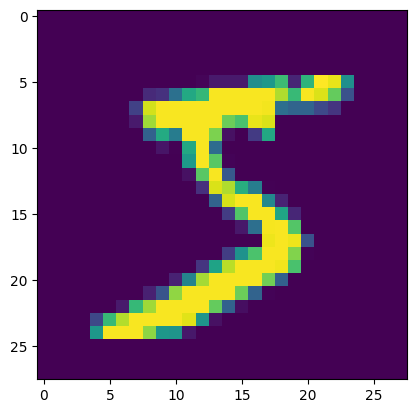

In [5]:
from torchvision import datasets
from torchvision import transforms 
from torch.utils.data import DataLoader 
from torch import nn
import torch.nn.functional as F
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt


RANDOM_SEED= 123
LEARNING_RATE = 0.1
NUM_EPOCHS = 10
BATCH_SIZE = 64



if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    DEVICE = torch.device("cpu")
    torch.manual_seed(RANDOM_SEED)
        
print('Using',DEVICE)




class MNIST(d2l.DataModule):
    def __init__(self, batch_size=BATCH_SIZE):
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.transform = d2l.transforms.Compose([
            d2l.transforms.ToTensor()])
        self.train_set = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
        self.val_set = datasets.MNIST(root='data', 
                              train=False,
                              transform=transforms.ToTensor())
        
    def get_dataloader(self, train):
        data = self.train_set if train else self.val_set
        return DataLoader(data, self.batch_size, shuffle=train)
        
data = MNIST()
print(f"Training dataset size: {len(data.train_set)}")
print(f"Validation dataset size: {len(data.val_set)}")
print(data.train_set[0][0].shape)
image_numpy = data.train_set[0][0].permute(1, 2, 0).cpu().numpy()
plt.imshow(image_numpy)
print(f"Image label: {data.train_set[0][1]}")



In [6]:
x, y = next(iter(data.train_dataloader()))
print(x.shape, x.dtype, y.shape, y.dtype)


torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64


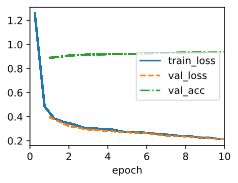

In [69]:
class MLP2a(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.Sigmoid(),
            nn.LazyLinear(num_outputs)
        )

model = MLP2a(num_outputs=10, num_hiddens=256, lr=LEARNING_RATE)
trainer = d2l.Trainer(max_epochs=NUM_EPOCHS,)
trainer.fit(model, data)


In [70]:
test_acc = d2l.evaluate_accuracy_gpu(model, data.val_dataloader())
print(f"Test accuracy: {test_acc * 100:.2f}%")

Test accuracy: 93.92%
